In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Background
## Using a "peeling" method to get layers in a directed, weighted graph. 

Here, I implement a model based on a probabilistic graph traversal model given in ([Schlegel et. al, eLife, 2021](https://doi.org/10.7554/eLife.66018)), which "peels" the graph to assign a numerical "layer" from a set of start nodes. 

The basic idea is that we have layers of nodes that we have visited at the same step, and the next layer is determined probabilistically based on the following arguments.

Suppose we have a weighted, directed adjacency matrix entry $A_{ij}$, giving the weight of the directed edge that links node $i$ to node $j$. 

Given a node $i$ which we've visited, the probability of traversing to $j$ in the next layer $p_{ij}$, should be proportional to the importance of node $i$ relative to all of node $j$'s in-partners:

p_{ij} \propto \frac{A_{ij}}{\sum_k A_{kj}} = \frac{A_{ij}}{s_{j}^{in}}
$$
$$
where $s_{j}^{in} = \sum_k A_{kj}$ is the in-strength. We can also define:  $s_{j}^{out} = \sum_k A_{jk}$ as the out-strength. 

Additionally, we want to bias the probability to select for nodes that are more outward than inward. This is because a given node is more likely to be higher up in the topological sort if the outgoing edge strength is greater than the incoming edge strength. So, this follows:

$$
p_{ij} \propto \frac{s_{j}^{out}}{s_{j}^{out} + s_{j}^{in}}.
$$

Altogether, we implement the model with the probability of getting picked in the next layer:
$$
p_{ij} = \frac{A_{ij}s_{j}^{out}}{s_{j}^{in}(s_{j}^{out} + s_{j}^{in})}
$$


## The data:

I'm using the [FlyWire minimum feedback challenge data set](https://codex.flywire.ai/app/mfas_challenge) as the test case. A topological sorting of a connectome can be useful in studying information flow and distribution. The challenge was to sort the neurons in the brain such that the sum of the edge weights directed backwards is minimised. 



In [2]:
edge_list = pd.read_csv('./data/connectome_graph.csv')
edge_list.rename(columns={'Source Node  ID':'pre', 'Target Node ID':'post', 'Edge Weight':'weight'}, inplace=True)
edge_list.pre = edge_list.pre.astype(str)
edge_list.post = edge_list.post.astype(str)

In [3]:
all_nodes = sorted(list(set(edge_list.pre.values) | set(edge_list.post.values)))

In [4]:
# Nodes that need sorting. Nodes that don't have any pre or post synapses do not need sorting.
changeable_nodes = sorted(list(set(edge_list.pre.values) & set(edge_list.post.values))) 

In [5]:
node_name_dict = dict(zip(all_nodes, range(len(all_nodes))))

edge_list.pre = edge_list.pre.apply(lambda x: node_name_dict[x])
edge_list.post = edge_list.post.apply(lambda x: node_name_dict[x])

### benchmark:

In [6]:
benchmark = pd.read_csv('./data/benchmark.csv')
benchmark.rename(columns={'Node ID':'n_id', 'Order':'order'}, inplace=True)
benchmark.n_id = benchmark.n_id.astype('str')
benchmark.n_id = benchmark.n_id.apply(lambda x: node_name_dict[x])

benchmark_dict = benchmark.set_index('n_id')['order'].to_dict()
benchmark_id_order = benchmark.n_id.tolist()

# how to calculate feedforwardness:
edge_list['pre_order'] = edge_list['pre'].apply(lambda x: benchmark_dict[x])
edge_list['post_order'] = edge_list['post'].apply(lambda x: benchmark_dict[x])

edge_list['is_forward'] = edge_list['pre_order'] - edge_list['post_order'] < 0

print('benchmark solution:', edge_list[edge_list['is_forward']].weight.sum())

benchmark solution: 29023882


# Imports:

In [7]:
# import the model:
from src.graphpeeler import layer_realisation

## Prepare probability of selection:

In [8]:
bodyId_posts = edge_list['post'].values
bodyId_pres = edge_list['pre'].values
out_only = list(set(bodyId_pres) - set(bodyId_posts)) # nodes that only have outedges.

in_strengths = edge_list.groupby('post').weight.sum().to_dict()
out_strengths = edge_list.groupby('pre').weight.sum().to_dict()

weights = edge_list['weight'].values
edge_df = edge_list.copy(True)

# weight of edges as a proportion of their strength:
edge_df['in_prop_weight'] = [weights[i]/in_strengths.get(bodyId_posts[i]) for i in range(len(edge_df))] 
edge_df['out_prop_weight'] = [weights[i]/out_strengths.get(bodyId_pres[i]) for i in range(len(edge_df))]

# out-strength as a proportion of the total in and out strength:
out_strength_prop = {i : out_strengths.get(i, 0)/(in_strengths.get(i, 0) + out_strengths.get(i, 0)) for i in list(node_name_dict.values())}


In [9]:
# combine to give: p_{ij}
edge_df['in_div_out_prop_weight'] = [weights[i]*out_strength_prop[bodyId_posts[i]]/in_strengths.get(bodyId_posts[i]) for i in range(len(edge_df))]

# run the model:

In [23]:
N = 50 # number of realisations
prepost = 'pre' # run the model forwards by taking the direction of traversal pre --> post. 
start_ids = out_only # start the 0th layer with nodes that don't have any preceding edges.

In [24]:
d_layers = []
for i in range(N): 
    nth_r = layer_realisation(df=edge_df, start_ids=start_ids, prepost=prepost, seed=i, prop_weight='in_div_out_prop_weight', correction=1)
    id_to_layer = {}
    for key, val in nth_r.items():
        for neuron in val:
            id_to_layer[neuron] = key
    d_layers.append(pd.Series(id_to_layer, name=f'r_{i}'))
# 13 mins for N=50

In [25]:
d_layer_df = pd.concat(d_layers, axis=1)
d_colname = f'm_ds_layer'
d_layer_df[d_colname] = d_layer_df.mean(axis=1).sort_values()#.round(0).astype(int) # take the mean layer across all the runs
d_layer_df.index.names=['bodyId']
d_layer_df = d_layer_df[[d_colname]]

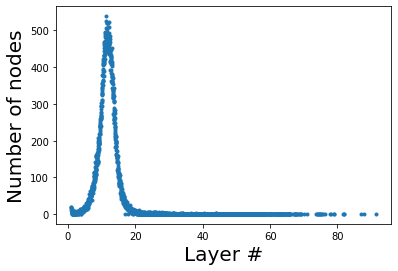

In [26]:
plt.plot(d_layer_df[d_layer_df[d_colname]>0].groupby(d_colname).apply(len), '.')
plt.xlabel('Layer #', size=20)
plt.ylabel('Number of nodes', size=20)
plt.show()

## evaluate the model

In [27]:
d_layer_df['benchmark'] = [benchmark_dict[x] for x in  d_layer_df.index.values]
sorted_d_layer_df = d_layer_df.sort_values([d_colname, 'benchmark'])
proposed_id_order = sorted_d_layer_df.index.values
proposed_id_order_dict = dict(zip(proposed_id_order, range(len(proposed_id_order))))

In [28]:
disconnected_neurons = set(benchmark_dict.keys()) - set(proposed_id_order_dict.keys())
from_benchmark_disconnected = {x:benchmark_dict[x]+len(all_nodes) for x in disconnected_neurons}
total_proposed_dict = proposed_id_order_dict | from_benchmark_disconnected


eval_df = edge_list.copy(True)
eval_df['pre_order'] = eval_df['pre'].apply(lambda x: total_proposed_dict[x])
eval_df['post_order'] = eval_df['post'].apply(lambda x: total_proposed_dict[x])
eval_df['is_forward'] = eval_df['pre_order'] - eval_df['post_order'] < 0

In [29]:
print('proposed solution:', eval_df[eval_df['is_forward']].weight.sum())
print('benchmark solution:', edge_list[edge_list['is_forward']].weight.sum())
score = eval_df[eval_df['is_forward']].weight.sum()/edge_list.weight.sum()
benchmark_comparison = eval_df[eval_df['is_forward']].weight.sum() -edge_list[edge_list['is_forward']].weight.sum()

print(f'Score: {score:.4f}')
print('Benchmark comparison:', benchmark_comparison)
print('\n')
if benchmark_comparison > 0:
    print('Does better than benchmark :)')
else:
    print('Does worse than benchmark :(')

proposed solution: 29193811
benchmark solution: 29023882
Score: 0.6965
Benchmark comparison: 169929


Does better than benchmark :)


### save as file:

In [30]:
numbername_node_dict = dict(zip(range(len(all_nodes)), all_nodes))
proposed_order = {numbername_node_dict[key]:val for key, val in total_proposed_dict.items()}

pd.DataFrame.from_dict(proposed_order, orient='index', columns=['Order']).reset_index().sort_values('Order').reset_index(drop=True).reset_index().iloc[:,:2].rename(columns={'level_0':'Order', 'index':'Node ID'}).set_index('Node ID').to_csv('./data/output.csv')